# Now I've gotta make sure that my sampling scheme for A, TKE, and Z is what I want. 
### It's way easier to do this in python, verify, and translate to C++ so that's what I'm gonna do

In [1]:
import numpy as np
import scipy as sp
import scipy.optimize as opt
import os
from statistics import *
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sympy as sym
from sympy.interactive import printing
printing.init_printing(use_latex = 'mathjax')
from IPython.display import display, Math, Latex
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.pyplot import cm
import pylab as pl
from scipy.stats import chisquare
import random
%matplotlib inline

In [2]:
import json

#-- Read JSON-formatted data file
def readJSONDataFile (filename):
    
    with open(filename) as jsonFile:
        jsonData = json.load(jsonFile)
        
    exp = list()
    c=0
    for item in jsonData.get("entries"):
        exp.append(item)
        c=c+1
        
    return exp

#-- Plot experimental data sets corresponding to a particular quantity
def plotExperimentalData (quantity, **keyword_parameters):
    if ('format' in keyword_parameters):
        fmtplot = keyword_parameters['format']
    else:
        fmtplot = 'ko--'

    checkAuthor = False
    if ('author' in keyword_parameters):
        author = keyword_parameters['author']
        checkAuthor = True
    for exp in experiments:
        if (exp['quantity']==quantity):
            if (checkAuthor):
                if (author not in exp['authors']):
                    continue
            data = np.asarray(exp['data'])
            if ('renorm' in exp):
                coef = exp['renorm']
            else:
                coef = 1.0
            x = data[:,0]
            y = data[:,1]
            if ('label' in keyword_parameters):
                labelplot = keyword_parameters['label']
            else:
                labelplot = exp['label']
            plt.plot(x,y*coef,fmtplot,alpha=0.5,label=labelplot)

#-- Lists all experiments read in 
def listExperimentalData (experiments):
    for exp in experiments:
        print ("{0:10s} |  {1}, {2}".format(exp['quantity'], exp['authors'], exp['year']))
        

In [3]:
EXPERIMENTALDATAFILE = "/home/austinlc/Documents/FromPTalou/expdata-98252sf.js"

In [98]:
experiments = readJSONDataFile (EXPERIMENTALDATAFILE)

for exp in experiments:
    print ("{0:20s} |  {1}, {2}".format(exp['quantity'], exp['authors'], exp['year']))

YA                   |  F.-J. Hambsch, S. Oberstedt, P. Siegler, J. van Arle, R. Vogt, 1997
YA                   |  C. Budtz-Joergensen and H.-H. Knitter, 1988
YA                   |  A. Gook, F.-J. Hambsch, M. Vidali, 2014
YA                   |  Sh. Zeynalov, F.-J.Hambsch, et al., 2011
YZ                   |  Wahl, 1987
TKEA                 |  Gook, 2014
SIGTKEA              |  A. Gook et al., 2014
Pnu                  |  P. Santi and M. Miller, 2008
PFNS                 |  W. Mannhart, 1989
PFNS2                |  W. Mannhart, 1989
nubarA               |  Vorobyev et al., 2004
EcmA                 |  Budtz-Jorgensen and Knitter, 1988
nubarTKE             |  A. Gook, F.-J. Hambsch, M. Vidali, 2014
nubarTKE_A110        |  A. Gook, F.-J. Hambsch, M. Vidali, 2014
nubarTKE_A122        |  A. Gook, F.-J. Hambsch, M. Vidali, 2014
nubarTKE_A130        |  A. Gook, F.-J. Hambsch, M. Vidali, 2014
nubarTKE_A142        |  A. Gook, F.-J. Hambsch, M. Vidali, 2014
nLF                  |  A. Skarsvag

In [5]:
### rcParams are the default parameters for matplotlib
import matplotlib as mpl

print ("Matplotbib Version: ", mpl.__version__)

mpl.rcParams['font.size'] = 18
mpl.rcParams['font.family'] = 'Helvetica', 'serif'
#mpl.rcParams['font.color'] = 'darkred'
mpl.rcParams['font.weight'] = 'normal'

mpl.rcParams['axes.labelsize'] = 18.
mpl.rcParams['xtick.labelsize'] = 18.
mpl.rcParams['ytick.labelsize'] = 18.
mpl.rcParams['lines.linewidth'] = 2.

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'normal',
        'size'   : 18,
        }

mpl.rcParams['xtick.major.pad']='10'
mpl.rcParams['ytick.major.pad']='10'

mpl.rcParams['image.cmap'] = 'inferno'

Matplotbib Version:  2.0.2


In [6]:
# Here are my effin sweet optimized parameters, see the MinimizeChi2Cf252.ipynb

dminl, dmin1, dmin2 = 1.67133975e+01, 1.08924571e+01,   1.44946848e+01
dmaxl, dmax1, dmax2 = 2.04274353e+01, 1.73227450e+01,   1.82042691e+01
ddecl, ddec1, ddec2 = 1.65676002e-01, 1.34703577e-01,   4.46051597e-01
Abarl, Abar1, Abar2 = 1.27530330e+02, 1.36328441e+02, 1.44542941e+02
sigAl, sigA1, sigA2 = 1.82257350e+01, 3.69590546e+00, 6.11049848e+00
hl, h1, h2 =          12303.67185349, 155112.69151267, 727073.51105839

# since we're not doing h's anymore, lemme take those and make them w's
wl = hl/(hl+h1+h2)
w1 = h1/(hl+h1+h2)
w2 = h2/(hl+h1+h2)

print(wl,w1,w2)

0.013754959340825731 0.1734091083059585 0.8128359323532158


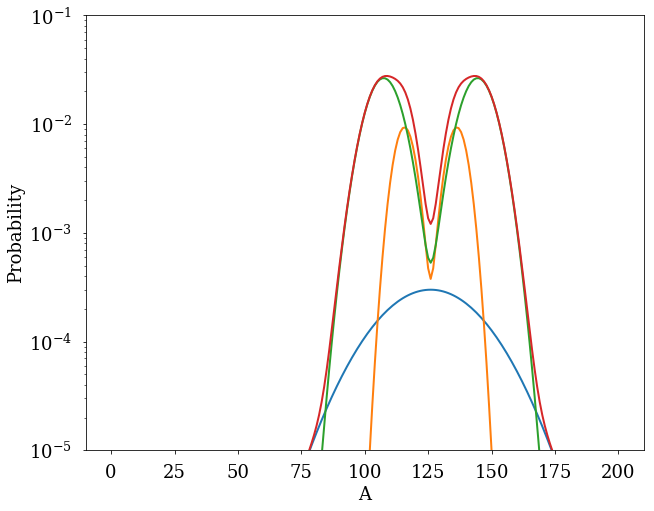

In [7]:
# okay now let's show the Yield of A, how it should be analytically and then come up with an algorithm
# to sample the gaussians and reproduce this yield

A = np.linspace(0,200,201)
A_cn = 252.
Z_cn = 98.
YA_sl = np.zeros(len(A)) 
YA_s1 = np.zeros(len(A)) 
YA_s2 = np.zeros(len(A))
YA = np.zeros(len(A))

for i in range(len(A)):
    YA_sl[i] = wl/np.sqrt(8*np.pi*sigAl**2) * \
                            (np.exp(-(A[i]-Abarl)**2/(2*sigAl**2)) + \
                             np.exp(-(A[i]-A_cn+Abarl)**2/(2*sigAl**2)))
        
    YA_s1[i] = w1/np.sqrt(8*np.pi*sigA1**2) * \
                        (np.exp(-(A[i]-Abar1)**2/(2*sigA1**2)) + \
                         np.exp(-(A[i]-A_cn+Abar1)**2/(2*sigA1**2)))
            
    YA_s2[i] = w2/np.sqrt(8*np.pi*sigA2**2) * \
                    (np.exp(-(A[i]-Abar2)**2/(2*sigA2**2)) + \
                     np.exp(-(A[i]-A_cn+Abar2)**2/(2*sigA2**2)))
        
    YA[i]    = YA_sl[i] + YA_s1[i] + YA_s2[i]
    
# so this is what the real thing should look like

fig, axes = pl.subplots(1, 1, figsize=(10, 8))

plt.semilogy(A, YA_sl)
plt.semilogy(A, YA_s1)
plt.semilogy(A, YA_s2)
plt.semilogy(A, YA)
plt.ylim(1e-5, 1e-1)
plt.xlabel('A')
plt.ylabel('Probability')

In [8]:
# similarly for TKE
TKE = np.linspace(100,299,200)
YTKE_sl = np.zeros(len(TKE)) 
YTKE_s1 = np.zeros(len(TKE)) 
YTKE_s2 = np.zeros(len(TKE))
YTKE    = np.zeros(len(TKE))

for i in range(len(TKE)):
    YTKE_sl



In [9]:
print(TKE)

[ 100.  101.  102.  103.  104.  105.  106.  107.  108.  109.  110.  111.
  112.  113.  114.  115.  116.  117.  118.  119.  120.  121.  122.  123.
  124.  125.  126.  127.  128.  129.  130.  131.  132.  133.  134.  135.
  136.  137.  138.  139.  140.  141.  142.  143.  144.  145.  146.  147.
  148.  149.  150.  151.  152.  153.  154.  155.  156.  157.  158.  159.
  160.  161.  162.  163.  164.  165.  166.  167.  168.  169.  170.  171.
  172.  173.  174.  175.  176.  177.  178.  179.  180.  181.  182.  183.
  184.  185.  186.  187.  188.  189.  190.  191.  192.  193.  194.  195.
  196.  197.  198.  199.  200.  201.  202.  203.  204.  205.  206.  207.
  208.  209.  210.  211.  212.  213.  214.  215.  216.  217.  218.  219.
  220.  221.  222.  223.  224.  225.  226.  227.  228.  229.  230.  231.
  232.  233.  234.  235.  236.  237.  238.  239.  240.  241.  242.  243.
  244.  245.  246.  247.  248.  249.  250.  251.  252.  253.  254.  255.
  256.  257.  258.  259.  260.  261.  262.  263.  2

In [10]:
# put into 2ists and 

# REARRANGE order: S2, S1, SL****
# ********************************
w = [w2, w1, wl]
dmin = [dmin2, dmin1, dminl]
dmax = [dmax2, dmax1, dmaxl]
ddec = [ddec2, ddec1, ddecl]
Abar = [Abar2, Abar1, Abarl]
sigA = [sigA2, sigA1, sigAl]


In [11]:
print(sigA)

[6.11049848, 3.69590546, 18.225735]


In [12]:
# let's get a sample scheme cooking for A
nhistories = 1000000
A_sampled = []
TKE_sampled = []



for i in range(nhistories):
    
    # 1) we gotta get a mode
    r1  = random.random()
    
    # sample probability mass dist
    wtot = 0.
    
    for i in range(3):
        wtot += w[i]
        if (r1 <= wtot):
            i_mode = i
            break
            
    # 2) let's sample the A based on the mode selected
    
    # sample mode based on gaussian
    r2 = random.random()
    r3 = random.random()
    A_s = Abar[i_mode] + sigA[i_mode] *np.sqrt(-2*np.log(r2)) * np.cos(2 * np.pi * r3)
    
    # now with given A, we can sample the TKE
    
    T = (Z_cn / A_cn)
    
    #symmetry
    if(random.random() <= 0.5):
        A_sampled.append(A_s)
    else:
        A_sampled.append(A_cn  - A_s)


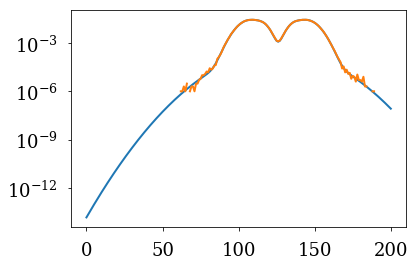

In [13]:
plt.semilogy(A, YA)
A_bins = np.linspace(-0.5, 200.5, 202)
A_binned = np.histogram(A_sampled, bins = A_bins, normed=True)
plt.semilogy(A,A_binned[0])

In [14]:
def TKEA(A, i_mode):
    TKE = np.linspace(100,299,200)
    e2 = 1.4399643929 # MeV fm
    # return a normalized probability mass function
    TKEA = np.zeros(len(TKE))
    for i in range(len(TKE)):
        T = (Z_cn/A_cn)**2 *(A_cn - A)*A*e2/TKE[i] - dmin[i_mode]
        # T cannot be <= 0 or overflow happens
        if (T > 0.):
            TKEA[i] = (200./TKE[i])**2 * np.exp(2.*(dmax[i_mode] -dmin[i_mode]) / ddec[i_mode] - 
                                         T/ddec[i_mode] - (dmax[i_mode] - dmin[i_mode])**2 /T/ddec[i_mode])
    total = sum(TKEA)
    if (total == 0.0): total = 0.01
    TKEA = np.asarray([float(i)/total for i in TKEA])
    return TKEA

In [15]:
TKEA_arr = np.zeros((3, len(A), len(TKE)))
for i in range(3):
    for j in range(len(A)):
        TKEA_arr[i,j,:] = TKEA(A[j], i)

In [16]:
Amin = int(min(A))
TKEmin = int(min(TKE))

def sampleTKE(A, i_mode):
    
    r4 = random.random()
    i_A = int(A - Amin)

        # sample probability mass dist
    KEtot = 0.
    
    for i_TKE in range(len(TKE)):
        KEtot += TKEA_arr[i_mode, i_A, i_TKE]
        if (r4 <= KEtot):
            return i_TKE + TKEmin


In [17]:
print(TKEmin)
print(A[22])
print(TKEA_arr[1, 22, :])

100
22.0
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]


(1e-07, 0.1)

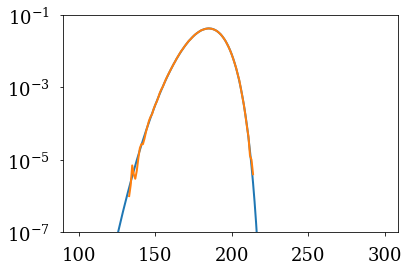

In [18]:
# look at just A=144
TKE_sampled = []
for i in range(nhistories):
    TKE_sampled.append(sampleTKE(144.,0))
    
plt.semilogy(TKE, TKEA(144., 0))
TKE_bins = np.linspace(99.5, 299.5, 201)
TKE_binned = np.histogram(TKE_sampled, bins = TKE_bins, normed=True)
plt.semilogy(TKE,TKE_binned[0])
plt.ylim(1e-7, 1e-1)

In [19]:
# now we move onto the Z|A distribution


Ac = A_cn
Zc = Z_cn
Zt = Zc
PE = 6.3
dZ = 7

delz = np.zeros(len(A))
sigz = np.zeros(len(A))
Fz = np.zeros(len(A))
Fn = np.zeros(len(A))

# compute wahl paramters
sigz140 = [0.566, 0.0, 0.0064, 0.0109, 0.0]
delz140 = [-0.487, 0.0, 0.0180, 0.0, -0.00203]
Fz140   = [1.242, 0.0, -0.0183, -0.0152, 0.0]
Fn140   = [1.076, 0.0, 0.0, 0.0, 0.0]
sigzSL  = [-0.0038, 0.0, 0.0, 0.0, 0.0]
delzSL  = [-0.0080, 0.0, 0.0, 0.0, 0.0]
FzSL    = [0.0030, 0.0, 0.0, 0.0, 0.0]
SL50    = [0.191, 0.0, -0.0076, 0.0, 0.0]
sigz50  = [0.356, 0.060, 0.0, 0.0, 0.0]
delzmax = [0.699, 0.0, 0.0, 0.0, 0.0]
sigzSLW = [-.045, 0.0094, 0.0, 0.0, 0.0]
delzSLW = [0.0, -0.0045, 0.0, 0.0, 0.0]
FzSLW   = [0.159, -0.028, 0.0, 0.0, 0.0]
FnSLW   = [0.039, 0.0, 0.0, 0.0, 0.0]

Z0 = np.zeros(len(A))
sZ0 = np.zeros(len(A))
FZZ0 = np.zeros(len(A))
FNZ0 = np.zeros(len(A))

sigz140t = sigz140[0]+sigz140[1]*(Zt-92)+sigz140[2]*(Ac-236)+sigz140[3]*(PE-6.551)+sigz140[4]*(Ac-236)*(Ac-236)
delz140t = delz140[0]+delz140[1]*(Zt-92)+delz140[2]*(Ac-236)+delz140[3]*(PE-6.551)+delz140[4]*(Ac-236)*(Ac-236)
Fz140t   = Fz140[0]+Fz140[1]*(Zt-92)+Fz140[2]*(Ac-236)+Fz140[3]*(PE-6.551)+Fz140[4]*(Ac-236)*(Ac-236)
Fn140t   = Fn140[0]+Fn140[1]*(Zt-92)+Fn140[2]*(Ac-236)+Fn140[3]*(PE-6.551)+Fn140[4]*(Ac-236)*(Ac-236)
sigzSLt  = sigzSL[0]+sigzSL[1]*(Zt-92)+sigzSL[2]*(Ac-236)+sigzSL[3]*(PE-6.551)+sigzSL[4]*(Ac-236)*(Ac-236)
delzSLt  = delzSL[0]+delzSL[1]*(Zt-92)+delzSL[2]*(Ac-236)+delzSL[3]*(PE-6.551)+delzSL[4]*(Ac-236)*(Ac-236)
FzSLt    = FzSL[0]+FzSL[1]*(Zt-92)+FzSL[2]*(Ac-236)+FzSL[3]*(PE-6.551)+FzSL[4]*(Ac-236)*(Ac-236)
SL50t    = SL50[0]+SL50[1]*(Zt-92)+SL50[2]*(Ac-236)+SL50[3]*(PE-6.551)+SL50[4]*(Ac-236)*(Ac-236)
sigz50t  = sigz50[0]+sigz50[1]*(Zt-92)+sigz50[2]*(Ac-236)+sigz50[3]*(PE-6.551)+sigz50[4]*(Ac-236)*(Ac-236)
delzmaxt = delzmax[0]+delzmax[1]*(Zt-92)+delzmax[2]*(Ac-236)+delzmax[3]*(PE-6.551)+delzmax[4]*(Ac-236)*(Ac-236)
sigzSLWt = sigzSLW[0]+sigzSLW[1]*(Zt-92)+sigzSLW[2]*(Ac-236)+sigzSLW[3]*(PE-6.551)+sigzSLW[4]*(Ac-236)*(Ac-236)
delzSLWt = delzSLW[0]+delzSLW[1]*(Zt-92)+delzSLW[2]*(Ac-236)+delzSLW[3]*(PE-6.551)+delzSLW[4]*(Ac-236)*(Ac-236)
FzSLWt   = FzSLW[0]+FzSLW[1]*(Zt-92)+FzSLW[2]*(Ac-236)+FzSLW[3]*(PE-6.551)+FzSLW[4]*(Ac-236)*(Ac-236)
FnSLWt   = FnSLW[0]+FnSLW[1]*(Zt-92)+FnSLW[2]*(Ac-236)+FnSLW[3]*(PE-6.551)+FnSLW[4]*(Ac-236)*(Ac-236)

F1=np.floor((250.-Ac)/14.+0.5)
F2=1.-F1
AK1=50.0*(Ac)/Zt-delzmaxt/SL50t
AK2=(50.0-delzmaxt)*(Ac)/Zt
Apmax=F1*AK1+F2*AK2

B1=70
B2=int(np.floor(77+0.036*(Ac-236)+0.5))
B4=int(np.floor((delzmaxt-delz140t+Apmax*SL50t+140*delzSLt)/(SL50t+delzSLt)+0.5))
B3=int(Ac-B4)
B5=int(Ac-B2)
B6=int(Ac-B1)
Bb=int(Apmax+0.5)
Ba=int(Ac-Apmax+0.5)






for i in range(len(A)): 
# Peak Regions
    if ((i>=B2 and i<=B3) or (i>=B4 and i<=B5)):
        if (i>Ac/2.0):
            delz[i]=delz140t+delzSLt*(i-140.0)
            sigz[i]=sigz140t+sigzSLt*(i-140.0)
            Fz[i]=Fz140t+FzSLt*(i-140.0)
            Fn[i]=Fn140t+FzSLt*(i-140.0)
        elif (i<Ac/2.0):
            delz[i]=-1*delz140t+delzSLt*(i-(Ac-140))
            sigz[i]=sigz140t-sigzSLt*(i-(Ac-140))
            Fz[i]=Fz140t-FzSLt*(i-(Ac-140))
            Fn[i]=Fn140t-FzSLt*(i-(Ac-140))
            
# Fn(i)=Fn140t
    


for i in range(len(A)): 
# Near Symmetry Region
    if (i>B3 and i<B4):
        Fn[i]=1.
        Fz[i]=1.
        if (i>B3 and i<=Ba):
            delz[i]=delz[B3]-SL50t*(i-B3)
            sigz[i]=sigz50t
        elif (i>Ba and i<Bb):
            delz[i]=delz[Ba]+(i-Ba)*(2.0*delz[Ba])/(Ba-Bb)
            sigz[i]=sigz140t-sigzSLt*(140-Bb)
        elif (i>=Bb and i<B4):
            delz[i]=delz[B4]+SL50t*(B4-i)
            sigz[i]=sigz50t


for i in range(len(A)): 
# Wing Regions
    if ((i>B1 and i<B2) or (i>B5 and i<B6)):
        if (i>Ac/2.0):
            delz[i]=delz[B5]-delzSLWt*(i-B5)
            sigz[i]=sigz[B5]+sigzSLWt*(i-B5)
            Fz[i]=Fz140t+FzSLWt*(i-B5)
            Fn[i]=Fn140t+FnSLWt*(i-B5)
        elif (i<Ac/2.0):
            delz[i]=delz[B2]+delzSLWt*(B2-i)
            sigz[i]=sigz[B5]+sigzSLWt*(B2-i)
            Fz[i]=Fz140t+FzSLWt*(B2-i)
            Fn[i]=Fn140t+FnSLWt*(B2-i)


# Far Wing Regions
if (i<=B1 or i>=B6):
    if (i>Ac/2.0):
        delz[i]=delz[B5]
        sigz[i]=sigz[B5]
        Fz[i]=Fz140t
        Fn[i]=Fn140t
    elif (i<Ac/2.0):
        delz[i]=delz[B2]
        sigz[i]=sigz[B5]
        Fz[i]=Fz140t
        Fn[i]=Fn140t

    
# save Wahl parameters
x = (Zt)/Ac
for i in range(len(A)): 
    Z0[i]   = (x*i+delz[i])
    sZ0[i]  = sigz[i]
    FZZ0[i] = Fz[i]
    FNZ0[i] = Fn[i]
    #    FZZ0[i] = 1.0
    #    FNZ0[i] = 1.0
    #    cout << i << " " << Z0[i] << " " << sZ0[i] << "\n"


#-- Find true (Zmin, Zmax)
Zmin = (int(np.floor(Z0[0]+0.5)-dZ))
Zmax = (int(np.floor(Z0[0]+0.5)+dZ))


(0, 2.5)

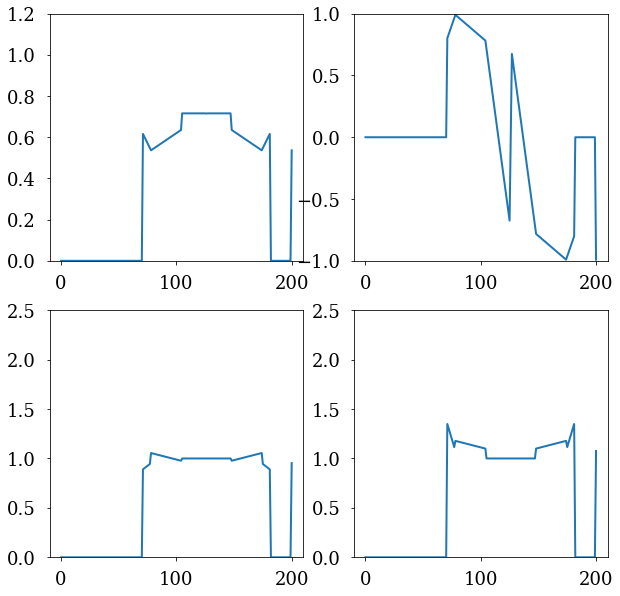

In [20]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(2,2,1)
plt.plot(A,sigz)
plt.ylim([0,1.2])

plt.subplot(2,2,2)
plt.plot(A,delz)
plt.ylim([-1.0,1.0])

plt.subplot(2,2,3)
plt.plot(A,Fz)
plt.ylim([0,2.5])

plt.subplot(2,2,4)
plt.plot(A,Fn)
plt.ylim([0,2.5])

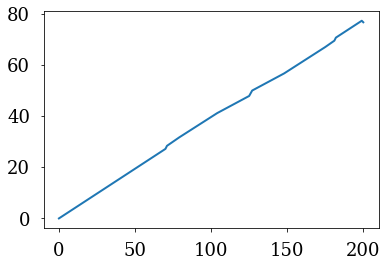

In [21]:
plt.plot(A,Z0)



In [22]:
# Now the buildYZA function

NUMZ = 100
NUMdZ = 21
NUMA = len(A)

YZA = np.zeros((NUMdZ, NUMA))
YZA2 = np.zeros((NUMZ, NUMA))

c=0.0
oddeven=1.0
  
sigma = 0.4
#  c=2.0*(sigma*sigma+1.0/12.0)
  
for i in range(len(A)):
    c = sZ0[i]
    Zp0 = Z0[i]
    iZp0 = int( np.floor(Zp0+0.5))
    
    for j in range(2*dZ+1):
      
        # Zi = Zp0+j-dZ
        iZ = iZp0+j-dZ
        YZA[j][i] = 0.0
        YZA2[iZ][i] = 0.0
      
        if (c>0.0):
            #    Zi = (int(Zp0+0.5)+j)
            if (iZ%2==0):
                if (i%2==0):
                    oddeven = FZZ0[i]*FNZ0[i] # even Z - even N
                else:
                    oddeven = FZZ0[i]/FNZ0[i] # even Z - odd N
            else:
                if ((i+1)%2==0):
                    oddeven = FNZ0[i]/FZZ0[i] # odd Z - even N
                else:
                    oddeven = 1.0/(FZZ0[i]*FNZ0[i]) # odd Z - odd N
        
            V = (iZ-Zp0+0.5)/(np.sqrt(2.0)*c)
            W = (iZ-Zp0-0.5)/(np.sqrt(2.0)*c)
        
            YZA[j][i] = oddeven * 0.5 * ( np.math.erf(V) - np.math.erf(W) ) # YA[i]
            YZA2[iZ][i] = YZA[j][i]
        
        #   ExpYields%Yza(j,i) = oddeven * 1.0_rk/np.sqrt(c*pi)*exp(-1.0_rk* ( Zi-Zp )**2/c) * 1.0_rk !ExpYields%Ya(i)
        
        else:
        
            if (j==dZ):
          #          YZA[j][i] = 1.0 # yields%Ya(i)
          #        	YZA2[iZ][i] = 1.0
              YZA[j][i] = YA[i]
              YZA2[iZ][i] = YA[i]

    # end loop over Z
    

    x=0
    for j in range(2*dZ +1):
        x += YZA[j][i]
    if (x!=0):
        for j in range(2*dZ +1):
            YZA[j][i] = YZA[j][i] * YA[i] / x
    
    y=0
    for j in range(NUMZ):
        y += YZA2[j][i]
    if (y!=0):
        for j in range(NUMZ):
            YZA2[j][i] = YZA2[j][i] * YA[i] / y


(20, 80)

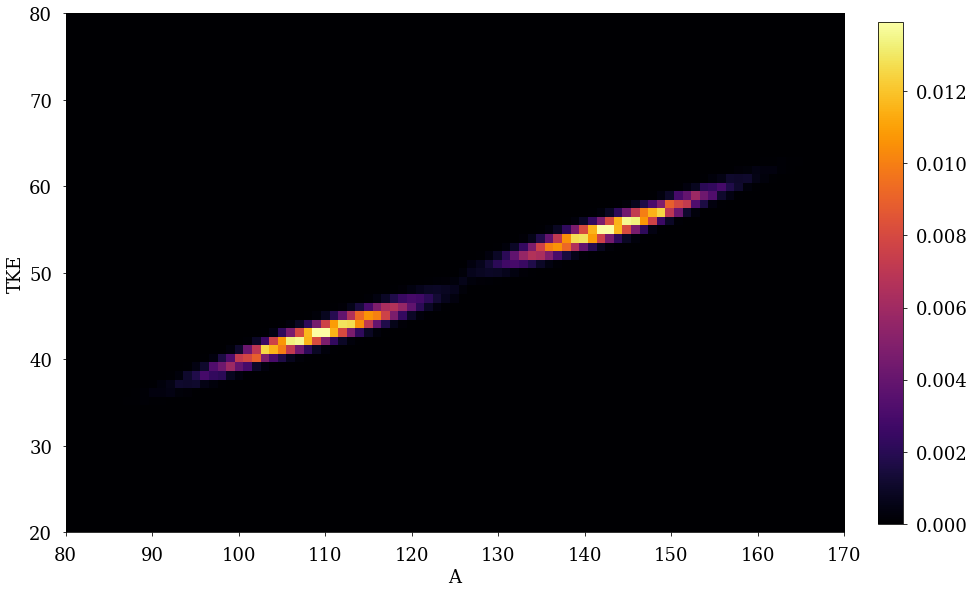

In [23]:

fig = plt.figure(figsize=(10, 10))

fig, axes = pl.subplots(1, 1, figsize=(15, 10))
c1 = plt.imshow(YZA2, extent=[0,200, 0,99], origin="lower")
plt.xlabel('A')
plt.ylabel('TKE')
plt.colorbar(fraction=0.03, pad=0.04)
plt.xlim(80,170)
plt.ylim(20,80)
    

48.9999909821
1.0
48.9999909821


(1e-06, 0.1)

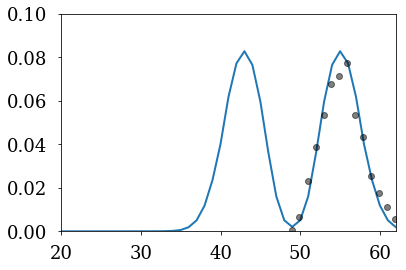

In [29]:
# make the Y(Z)
YZ = np.zeros(NUMZ)
Z = np.linspace(0,99., NUMZ)
YieldAZ = np.zeros(YZA2.shape)

for i in range(len(A)):
    for j in range(len(Z)):
        YieldAZ[j, i] = 2 * YZA2[j,i]
    
for j in range(len(Z)):
    YZ[j] = sum(YieldAZ[j,:])
    
# renorm YZ
total = sum(YZ)
YZ = np.asarray([float(i)/total for i in YZ])
        
plt.plot(Z,YZ)
plt.xlim([20, 62])
print(sum(np.multiply(Z,YZ)))
print(sum(YZ))



print(sum(np.multiply(Z,YZ)) /sum(YZ))

plotExperimentalData ('YZ',format='ko') 
plt.ylim([1e-6, 1e-1])

(1e-07, 0.1)

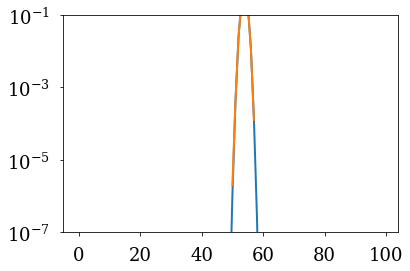

In [82]:
# how the eff do we sample this now?

def sampleYZA( A):
    
    
    
    r5 = random.random()

    i_A = A - Amin
    #normalize the column vector to =1
    YZA_tot  = sum(YZA2[:, i_A])
    YZA_temp = np.asarray([float(i)/YZA_tot for i in YZA2[:,i_A]])
    
    # sample probability mass dist
    Ztot = 0.
    
    for i_Z in range(NUMZ):
        Ztot += YZA_temp[i_Z]
        if (r5 <= Ztot):
            return i_Z

Z_sampled = []
# quick demonstration
for i in range(nhistories):
    Z_sampled.append(sampleYZA(139))

total  = sum(YZA2[:, 139])
Z_compare = np.asarray([float(i)/total for i in YZA2[:,139]])

plt.semilogy(Z, Z_compare)
Z_bins = np.linspace(-0.5, float(NUMZ) - 0.5, 101)
Z_binned = np.histogram(Z_sampled, bins = Z_bins, normed=True)
plt.semilogy(Z,Z_binned[0])
plt.ylim(1e-7, 1e-1)



In [83]:
print(mean(Z_sampled))

53.8978


In [70]:
w0 = np.linspace(0.6, 0.82, 10)

for i in range(len(w0)):
    print(w0[i])
    print(1. - w0[i] - w[1])

0.6
0.226590891694
0.624444444444
0.20214644725
0.648888888889
0.177702002805
0.673333333333
0.153257558361
0.697777777778
0.128813113916
0.722222222222
0.104368669472
0.746666666667
0.0799242250274
0.771111111111
0.0554797805829
0.795555555556
0.0310353361385
0.82
0.00659089169404


In [76]:
Abar[2] = 126.

In [81]:
DATADIR = '/home/austinlc/Documents/FromPTalou/CGMF-Version-1.0.7.2/data/'
w0 = np.linspace(0.6, 0.82, 10)
for i in range(0,10):

    with open('BrosaYields'+str(i+1)+'.dat','w') as f:
        f.write('// Cf252 Brosa Mode data:\n')
        f.write('98252\n')
        f.write('w '+str(w0[i]) + ' ' + str(w[1]) + ' ' + str(1. - w0[i] - w[1]) + '\n')
        f.write('dmin '+str(dmin[0]) + ' ' + str(dmin[1]) + ' ' + str(dmin[2]) + '\n')
        f.write('dmax '+str(dmax[0]) + ' ' + str(dmax[1]) + ' ' + str(dmax[2]) + '\n')
        f.write('ddec '+str(ddec[0]) + ' ' + str(ddec[1]) + ' ' + str(ddec[2]) + '\n')
        f.write('Abar '+str(Abar[0]) + ' ' + str(Abar[1]) + ' ' + str(Abar[2]) + '\n')
        f.write('sigA '+str(sigA[0]) + ' ' + str(sigA[1]) + ' ' + str(sigA[2]) + '\n')
        
w1 = np.linspace(0.15, 0.25, 10)
for i in range(0,10):

    with open('BrosaYields'+str(i+11)+'.dat','w') as f:
        f.write('// Cf252 Brosa Mode data:\n')
        f.write('98252\n')
        f.write('w '+str(1.-w1[i]-w[2]) + ' ' + str(w1[i]) + ' ' + str(w[2]) + '\n')
        f.write('dmin '+str(dmin[0]) + ' ' + str(dmin[1]) + ' ' + str(dmin[2]) + '\n')
        f.write('dmax '+str(dmax[0]) + ' ' + str(dmax[1]) + ' ' + str(dmax[2]) + '\n')
        f.write('ddec '+str(ddec[0]) + ' ' + str(ddec[1]) + ' ' + str(ddec[2]) + '\n')
        f.write('Abar '+str(Abar[0]) + ' ' + str(Abar[1]) + ' ' + str(Abar[2]) + '\n')
        f.write('sigA '+str(sigA[0]) + ' ' + str(sigA[1]) + ' ' + str(sigA[2]) + '\n')
        
w2 = np.linspace(0.001, 0.07, 10)
for i in range(0,10):

    with open('BrosaYields'+str(i+21)+'.dat','w') as f:
        f.write('// Cf252 Brosa Mode data:\n')
        f.write('98252\n')
        f.write('w '+str(w[0]) + ' ' + str(1.0 - w2[i] - w[0]) + ' ' + str(w2[i]) + '\n')
        f.write('dmin '+str(dmin[0]) + ' ' + str(dmin[1]) + ' ' + str(dmin[2]) + '\n')
        f.write('dmax '+str(dmax[0]) + ' ' + str(dmax[1]) + ' ' + str(dmax[2]) + '\n')
        f.write('ddec '+str(ddec[0]) + ' ' + str(ddec[1]) + ' ' + str(ddec[2]) + '\n')
        f.write('Abar '+str(Abar[0]) + ' ' + str(Abar[1]) + ' ' + str(Abar[2]) + '\n')
        f.write('sigA '+str(sigA[0]) + ' ' + str(sigA[1]) + ' ' + str(sigA[2]) + '\n')
        
dmin0 = np.linspace(10.,18.,10)
for i in range(0,10):

    with open('BrosaYields'+str(i+31)+'.dat','w') as f:
        f.write('// Cf252 Brosa Mode data:\n')
        f.write('98252\n')
        f.write('w '+str(w[0]) + ' ' + str(w[1]) + ' ' + str(w[2]) + '\n')
        f.write('dmin '+str(dmin0[i]) + ' ' + str(dmin[1]) + ' ' + str(dmin[2]) + '\n')
        f.write('dmax '+str(dmax[0]) + ' ' + str(dmax[1]) + ' ' + str(dmax[2]) + '\n')
        f.write('ddec '+str(ddec[0]) + ' ' + str(ddec[1]) + ' ' + str(ddec[2]) + '\n')
        f.write('Abar '+str(Abar[0]) + ' ' + str(Abar[1]) + ' ' + str(Abar[2]) + '\n')
        f.write('sigA '+str(sigA[0]) + ' ' + str(sigA[1]) + ' ' + str(sigA[2]) + '\n')

        
dmin1 = np.linspace(6.,16.,10)
for i in range(0,10):

    with open('BrosaYields'+str(i+41)+'.dat','w') as f:
        f.write('// Cf252 Brosa Mode data:\n')
        f.write('98252\n')
        f.write('w '+str(w[0]) + ' ' + str(w[1]) + ' ' + str(w[2]) + '\n')
        f.write('dmin '+str(dmin[0]) + ' ' + str(dmin1[i]) + ' ' + str(dmin[2]) + '\n')
        f.write('dmax '+str(dmax[0]) + ' ' + str(dmax[1]) + ' ' + str(dmax[2]) + '\n')
        f.write('ddec '+str(ddec[0]) + ' ' + str(ddec[1]) + ' ' + str(ddec[2]) + '\n')
        f.write('Abar '+str(Abar[0]) + ' ' + str(Abar[1]) + ' ' + str(Abar[2]) + '\n')
        f.write('sigA '+str(sigA[0]) + ' ' + str(sigA[1]) + ' ' + str(sigA[2]) + '\n')
        
dmin2 = np.linspace(10.,20.,10)
for i in range(0,10):

    with open('BrosaYields'+str(i+51)+'.dat','w') as f:
        f.write('// Cf252 Brosa Mode data:\n')
        f.write('98252\n')
        f.write('w '+str(w[0]) + ' ' + str(w[1]) + ' ' + str(w[2]) + '\n')
        f.write('dmin '+str(dmin[0]) + ' ' + str(dmin[1]) + ' ' + str(dmin2[i]) + '\n')
        f.write('dmax '+str(dmax[0]) + ' ' + str(dmax[1]) + ' ' + str(dmax[2]) + '\n')
        f.write('ddec '+str(ddec[0]) + ' ' + str(ddec[1]) + ' ' + str(ddec[2]) + '\n')
        f.write('Abar '+str(Abar[0]) + ' ' + str(Abar[1]) + ' ' + str(Abar[2]) + '\n')
        f.write('sigA '+str(sigA[0]) + ' ' + str(sigA[1]) + ' ' + str(sigA[2]) + '\n')
        
dmax0 = np.linspace(15.,24.,10)
for i in range(0,10):

    with open('BrosaYields'+str(i+61)+'.dat','w') as f:
        f.write('// Cf252 Brosa Mode data:\n')
        f.write('98252\n')
        f.write('w '+str(w[0]) + ' ' + str(w[1]) + ' ' + str(w[2]) + '\n')
        f.write('dmin '+str(dmin[0]) + ' ' + str(dmin[1]) + ' ' + str(dmin[2]) + '\n')
        f.write('dmax '+str(dmax0[i]) + ' ' + str(dmax[1]) + ' ' + str(dmax[2]) + '\n')
        f.write('ddec '+str(ddec[0]) + ' ' + str(ddec[1]) + ' ' + str(ddec[2]) + '\n')
        f.write('Abar '+str(Abar[0]) + ' ' + str(Abar[1]) + ' ' + str(Abar[2]) + '\n')
        f.write('sigA '+str(sigA[0]) + ' ' + str(sigA[1]) + ' ' + str(sigA[2]) + '\n')
        
dmax1 = np.linspace(12.,21.,10)
for i in range(0,10):

    with open('BrosaYields'+str(i+71)+'.dat','w') as f:
        f.write('// Cf252 Brosa Mode data:\n')
        f.write('98252\n')
        f.write('w '+str(w[0]) + ' ' + str(w[1]) + ' ' + str(w[2]) + '\n')
        f.write('dmin '+str(dmin[0]) + ' ' + str(dmin[1]) + ' ' + str(dmin[2]) + '\n')
        f.write('dmax '+str(dmax[0]) + ' ' + str(dmax1[i]) + ' ' + str(dmax[2]) + '\n')
        f.write('ddec '+str(ddec[0]) + ' ' + str(ddec[1]) + ' ' + str(ddec[2]) + '\n')
        f.write('Abar '+str(Abar[0]) + ' ' + str(Abar[1]) + ' ' + str(Abar[2]) + '\n')
        f.write('sigA '+str(sigA[0]) + ' ' + str(sigA[1]) + ' ' + str(sigA[2]) + '\n')
        
dmax2 = np.linspace(17.,26.,10)
for i in range(0,10):

    with open('BrosaYields'+str(i+81)+'.dat','w') as f:
        f.write('// Cf252 Brosa Mode data:\n')
        f.write('98252\n')
        f.write('w '+str(w[0]) + ' ' + str(w[1]) + ' ' + str(w[2]) + '\n')
        f.write('dmin '+str(dmin[0]) + ' ' + str(dmin[1]) + ' ' + str(dmin[2]) + '\n')
        f.write('dmax '+str(dmax[0]) + ' ' + str(dmax[1]) + ' ' + str(dmax2[i]) + '\n')
        f.write('ddec '+str(ddec[0]) + ' ' + str(ddec[1]) + ' ' + str(ddec[2]) + '\n')
        f.write('Abar '+str(Abar[0]) + ' ' + str(Abar[1]) + ' ' + str(Abar[2]) + '\n')
        f.write('sigA '+str(sigA[0]) + ' ' + str(sigA[1]) + ' ' + str(sigA[2]) + '\n')
        
ddec0 = np.linspace(0.2,0.8,10)
for i in range(0,10):

    with open('BrosaYields'+str(i+91)+'.dat','w') as f:
        f.write('// Cf252 Brosa Mode data:\n')
        f.write('98252\n')
        f.write('w '+str(w[0]) + ' ' + str(w[1]) + ' ' + str(w[2]) + '\n')
        f.write('dmin '+str(dmin[0]) + ' ' + str(dmin[1]) + ' ' + str(dmin[2]) + '\n')
        f.write('dmax '+str(dmax[0]) + ' ' + str(dmax[1]) + ' ' + str(dmax[2]) + '\n')
        f.write('ddec '+str(ddec0[i]) + ' ' + str(ddec[1]) + ' ' + str(ddec[2]) + '\n')
        f.write('Abar '+str(Abar[0]) + ' ' + str(Abar[1]) + ' ' + str(Abar[2]) + '\n')
        f.write('sigA '+str(sigA[0]) + ' ' + str(sigA[1]) + ' ' + str(sigA[2]) + '\n')
        
ddec1 = np.linspace(0.05,0.3,10)
for i in range(0,10):

    with open('BrosaYields'+str(i+101)+'.dat','w') as f:
        f.write('// Cf252 Brosa Mode data:\n')
        f.write('98252\n')
        f.write('w '+str(w[0]) + ' ' + str(w[1]) + ' ' + str(w[2]) + '\n')
        f.write('dmin '+str(dmin[0]) + ' ' + str(dmin[1]) + ' ' + str(dmin[2]) + '\n')
        f.write('dmax '+str(dmax[0]) + ' ' + str(dmax[1]) + ' ' + str(dmax[2]) + '\n')
        f.write('ddec '+str(ddec[0]) + ' ' + str(ddec1[i]) + ' ' + str(ddec[2]) + '\n')
        f.write('Abar '+str(Abar[0]) + ' ' + str(Abar[1]) + ' ' + str(Abar[2]) + '\n')
        f.write('sigA '+str(sigA[0]) + ' ' + str(sigA[1]) + ' ' + str(sigA[2]) + '\n')
        
ddec2 = np.linspace(0.05,0.4,10)
for i in range(0,10):

    with open('BrosaYields'+str(i+111)+'.dat','w') as f:
        f.write('// Cf252 Brosa Mode data:\n')
        f.write('98252\n')
        f.write('w '+str(w[0]) + ' ' + str(w[1]) + ' ' + str(w[2]) + '\n')
        f.write('dmin '+str(dmin[0]) + ' ' + str(dmin[1]) + ' ' + str(dmin[2]) + '\n')
        f.write('dmax '+str(dmax[0]) + ' ' + str(dmax[1]) + ' ' + str(dmax[2]) + '\n')
        f.write('ddec '+str(ddec[0]) + ' ' + str(ddec[1]) + ' ' + str(ddec2[i]) + '\n')
        f.write('Abar '+str(Abar[0]) + ' ' + str(Abar[1]) + ' ' + str(Abar[2]) + '\n')
        f.write('sigA '+str(sigA[0]) + ' ' + str(sigA[1]) + ' ' + str(sigA[2]) + '\n')
        
Abar0 = np.linspace(139.,149.,10)
for i in range(0,10):

    with open('BrosaYields'+str(i+121)+'.dat','w') as f:
        f.write('// Cf252 Brosa Mode data:\n')
        f.write('98252\n')
        f.write('w '+str(w[0]) + ' ' + str(w[1]) + ' ' + str(w[2]) + '\n')
        f.write('dmin '+str(dmin[0]) + ' ' + str(dmin[1]) + ' ' + str(dmin[2]) + '\n')
        f.write('dmax '+str(dmax[0]) + ' ' + str(dmax[1]) + ' ' + str(dmax[2]) + '\n')
        f.write('ddec '+str(ddec[0]) + ' ' + str(ddec[1]) + ' ' + str(ddec[2]) + '\n')
        f.write('Abar '+str(Abar0[i]) + ' ' + str(Abar[1]) + ' ' + str(Abar[2]) + '\n')
        f.write('sigA '+str(sigA[0]) + ' ' + str(sigA[1]) + ' ' + str(sigA[2]) + '\n')
        
Abar1 = np.linspace(128.,140.,10)
for i in range(0,10):

    with open('BrosaYields'+str(i+131)+'.dat','w') as f:
        f.write('// Cf252 Brosa Mode data:\n')
        f.write('98252\n')
        f.write('w '+str(w[0]) + ' ' + str(w[1]) + ' ' + str(w[2]) + '\n')
        f.write('dmin '+str(dmin[0]) + ' ' + str(dmin[1]) + ' ' + str(dmin[2]) + '\n')
        f.write('dmax '+str(dmax[0]) + ' ' + str(dmax[1]) + ' ' + str(dmax[2]) + '\n')
        f.write('ddec '+str(ddec[0]) + ' ' + str(ddec[1]) + ' ' + str(ddec[2]) + '\n')
        f.write('Abar '+str(Abar[0]) + ' ' + str(Abar1[i]) + ' ' + str(Abar[2]) + '\n')
        f.write('sigA '+str(sigA[0]) + ' ' + str(sigA[1]) + ' ' + str(sigA[2]) + '\n')
        
sigA0 = np.linspace(4.0,8.0,10)
for i in range(0,10):

    with open('BrosaYields'+str(i+141)+'.dat','w') as f:
        f.write('// Cf252 Brosa Mode data:\n')
        f.write('98252\n')
        f.write('w '+str(w[0]) + ' ' + str(w[1]) + ' ' + str(w[2]) + '\n')
        f.write('dmin '+str(dmin[0]) + ' ' + str(dmin[1]) + ' ' + str(dmin[2]) + '\n')
        f.write('dmax '+str(dmax[0]) + ' ' + str(dmax[1]) + ' ' + str(dmax[2]) + '\n')
        f.write('ddec '+str(ddec[0]) + ' ' + str(ddec[1]) + ' ' + str(ddec[2]) + '\n')
        f.write('Abar '+str(Abar[0]) + ' ' + str(Abar[1]) + ' ' + str(Abar[2]) + '\n')
        f.write('sigA '+str(sigA0[i]) + ' ' + str(sigA[1]) + ' ' + str(sigA[2]) + '\n')
        
sigA1 = np.linspace(2.5,5.5,10)
for i in range(0,10):

    with open('BrosaYields'+str(i+151)+'.dat','w') as f:
        f.write('// Cf252 Brosa Mode data:\n')
        f.write('98252\n')
        f.write('w '+str(w[0]) + ' ' + str(w[1]) + ' ' + str(w[2]) + '\n')
        f.write('dmin '+str(dmin[0]) + ' ' + str(dmin[1]) + ' ' + str(dmin[2]) + '\n')
        f.write('dmax '+str(dmax[0]) + ' ' + str(dmax[1]) + ' ' + str(dmax[2]) + '\n')
        f.write('ddec '+str(ddec[0]) + ' ' + str(ddec[1]) + ' ' + str(ddec[2]) + '\n')
        f.write('Abar '+str(Abar[0]) + ' ' + str(Abar[1]) + ' ' + str(Abar[2]) + '\n')
        f.write('sigA '+str(sigA[0]) + ' ' + str(sigA1[i]) + ' ' + str(sigA[2]) + '\n')
        
sigA2 = np.linspace(12.0,30.0,10)
for i in range(0,10):

    with open('BrosaYields'+str(i+161)+'.dat','w') as f:
        f.write('// Cf252 Brosa Mode data:\n')
        f.write('98252\n')
        f.write('w '+str(w[0]) + ' ' + str(w[1]) + ' ' + str(w[2]) + '\n')
        f.write('dmin '+str(dmin[0]) + ' ' + str(dmin[1]) + ' ' + str(dmin[2]) + '\n')
        f.write('dmax '+str(dmax[0]) + ' ' + str(dmax[1]) + ' ' + str(dmax[2]) + '\n')
        f.write('ddec '+str(ddec[0]) + ' ' + str(ddec[1]) + ' ' + str(ddec[2]) + '\n')
        f.write('Abar '+str(Abar[0]) + ' ' + str(Abar[1]) + ' ' + str(Abar[2]) + '\n')
        f.write('sigA '+str(sigA[0]) + ' ' + str(sigA[1]) + ' ' + str(sigA2[i]) + '\n')

In [104]:
# verify that Yields are reproduced correctly
A_file    = []
YA_file   = []
Z_file    = []
YZ_file   = []
TKE_file  = []
YTKE_file = []

with open('yields.out','r') as f:
    (f.readline())
    (f.readline())
    for i in range(3, 138):
        # YA
        line = f.readline()
        line = line.split()
        A_file.append(int(line[0]))
        YA_file.append(float(line[1]))
    (f.readline())
    (f.readline())
    (f.readline())
    
    for i in range(141, 196):
        # YZ
        line = f.readline()
        line = line.split()
        Z_file.append(int(line[0]))
        YZ_file.append(float(line[1])/2)
        
    (f.readline())
    (f.readline())
    (f.readline())
    
    for i in range(199, 302):
        # YTKE
        line = f.readline()
        line = line.split()
        TKE_file.append(int(line[0]))
        YTKE_file.append(float(line[1]))
    

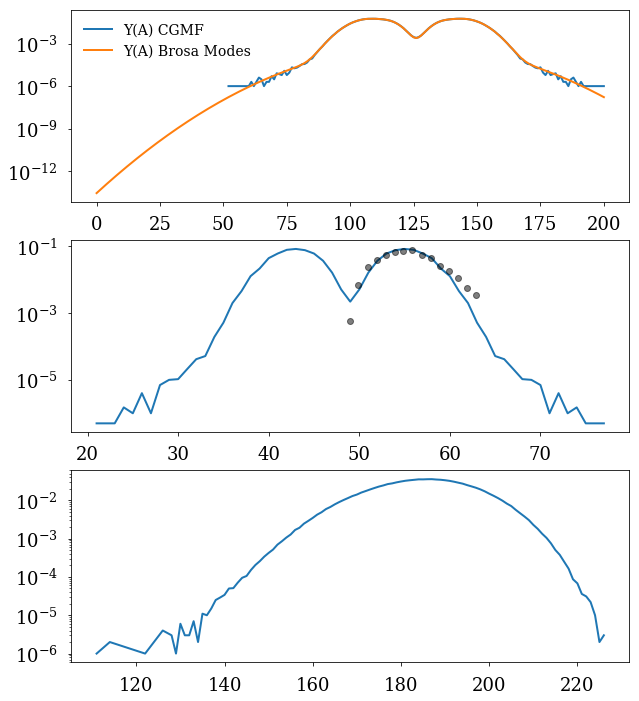

In [109]:
fig, axes = pl.subplots(1, 1, figsize=(10, 12))
plt.subplot(3,1,1)
plt.semilogy(A_file, YA_file, label='Y(A) CGMF')
plt.semilogy(A, 2*YA, label='Y(A) Brosa Modes')

lg = plt.legend(fontsize=14,numpoints=1)
lg.draw_frame(False)
plt.subplot(3,1,2)
plt.semilogy(Z_file, YZ_file)
plotExperimentalData ('YZ',format='ko') 
plt.subplot(3,1,3)
plt.semilogy(TKE_file, YTKE_file)


In [129]:
# one final look at the yields that were produced
#specifically TKE|A

# verify that Yields are reproduced correctly
A_file2 = []
TKE_file2 = []

with open('yields','r') as f:
    for i in range(0, 100000):
        # YA
        line = f.readline()
        line = line.split()
        A_file2.append(int(line[1]))
        if (i%2 == 1):
            TKE_file2.append(float(line[2]) + TKEprev)
            TKE_file2.append(float(line[2]) + TKEprev)
        else:
            TKEprev = float(line[2])
            
TKEA_file =  np.zeros(200)
counter_arr = np.zeros(200)
for i in range(len(A_file2)):
    TKEA_file[A_file2[i]] += TKE_file2[i]
    counter_arr[A_file2[i]] += 1
    
for i in range(200):
    if (counter_arr[i] >0):
        TKEA_file[i] = TKEA_file[i]/counter_arr[i]
print(A_file2[0:100])

print(TKEA_file)

[102, 150, 106, 146, 110, 142, 113, 139, 115, 137, 114, 138, 116, 136, 99, 153, 112, 140, 101, 151, 100, 152, 111, 141, 109, 143, 114, 138, 113, 139, 114, 138, 120, 132, 110, 142, 116, 136, 119, 133, 105, 147, 101, 151, 99, 153, 109, 143, 111, 141, 117, 135, 108, 144, 113, 139, 105, 147, 122, 130, 104, 148, 112, 140, 105, 147, 109, 143, 107, 145, 109, 143, 107, 145, 97, 155, 115, 137, 110, 142, 106, 146, 110, 142, 116, 136, 93, 159, 101, 151, 114, 138, 111, 141, 106, 146, 114, 138, 115, 137]
[   0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.            0.       

(125, 200)

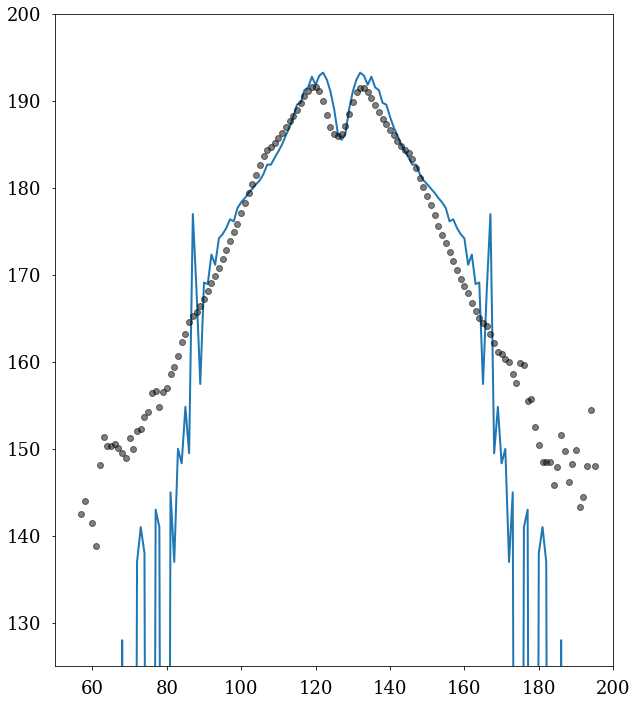

In [133]:
fig, axes = pl.subplots(1, 1, figsize=(10, 12))
plt.plot(np.linspace(1,200,200), TKEA_file)
plotExperimentalData ('TKEA',format='ko') 
plt.xlim([50, 200])
plt.ylim([125, 200])

In [120]:
i = 2
print(i%2)

0
